In [71]:
import numpy as np
import pandas as pd

from time import time
from datetime import timedelta

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.seasonal import STL

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt

# Data collection

In [3]:
def read_tide(filepath, datetime_pattern=slice(0,13)):
    df = pd.read_csv(filepath)
    df['Date Time'] = [date[datetime_pattern] for date in df['Date Time']]
    df['Date Time'] = pd.to_datetime(df['Date Time'])
    df = df.groupby(['Date Time']).mean()
    return df.reset_index()

In [4]:
orig_train = read_tide('BHPtraining.csv')
orig_test = read_tide('BHPtest.csv')

# Data cleaning

## Convert it to hourly

In [5]:
orig_train

,Date Time,Air Temperature,Water Level,Water Level Sigma,Wind Speed,Wind Direction,Wind Gust
0,2017-01-01 00:00:00,63.90,2.4475,0.1492,4.860,136.111111,5.355556
1,2017-01-01 01:00:00,63.98,2.2461,0.1629,4.237,134.200000,4.666000
2,2017-01-01 02:00:00,64.18,2.2506,0.1539,5.073,129.700000,5.404000
3,2017-01-01 03:00:00,64.30,2.1027,0.1608,5.015,112.200000,5.287000
4,2017-01-01 04:00:00,64.18,2.0279,0.1686,6.725,82.800000,7.115000
...,...,...,...,...,...,...,...
26275,2019-12-31 19:00:00,59.56,0.5822,0.2331,14.929,27.500000,17.630000
26276,2019-12-31 20:00:00,59.27,0.7208,0.2327,14.346,27.900000,17.027000
26277,2019-12-31 21:00:00,59.08,0.9824,0.2450,13.550,28.200000,16.327000
26278,2019-12-31 22:00:00,58.72,1.2382,0.2184,14.112,26.100000,16.619000


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001D779B87588>,
      dtype=object)

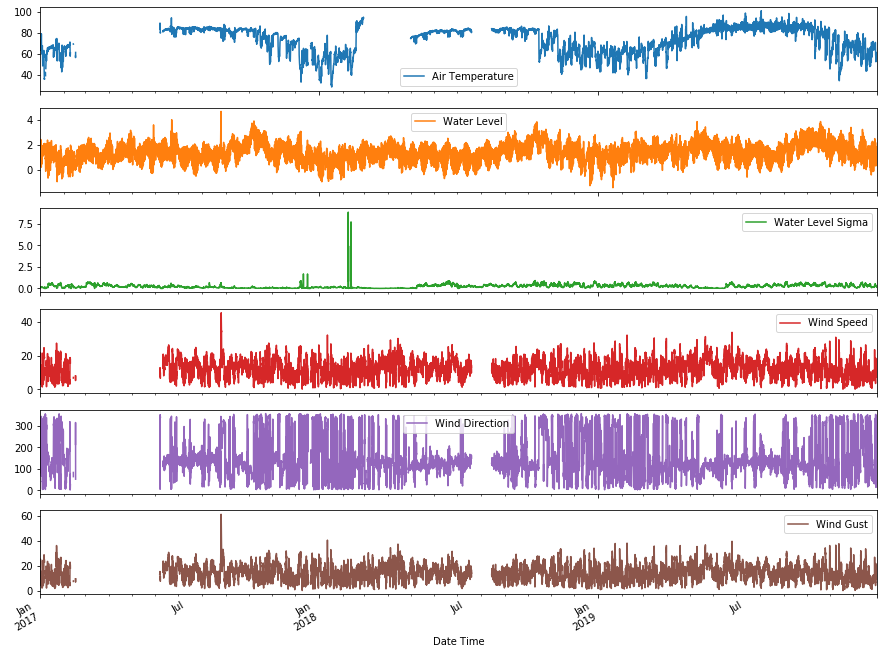

In [6]:
orig_train.plot(x='Date Time', figsize=(15, 12), subplots=True)

## Remove missing values

In [7]:
def clean_tide_data(df):
    cleaned = df.copy()
    cleaned.dropna(inplace=True)
    return cleaned

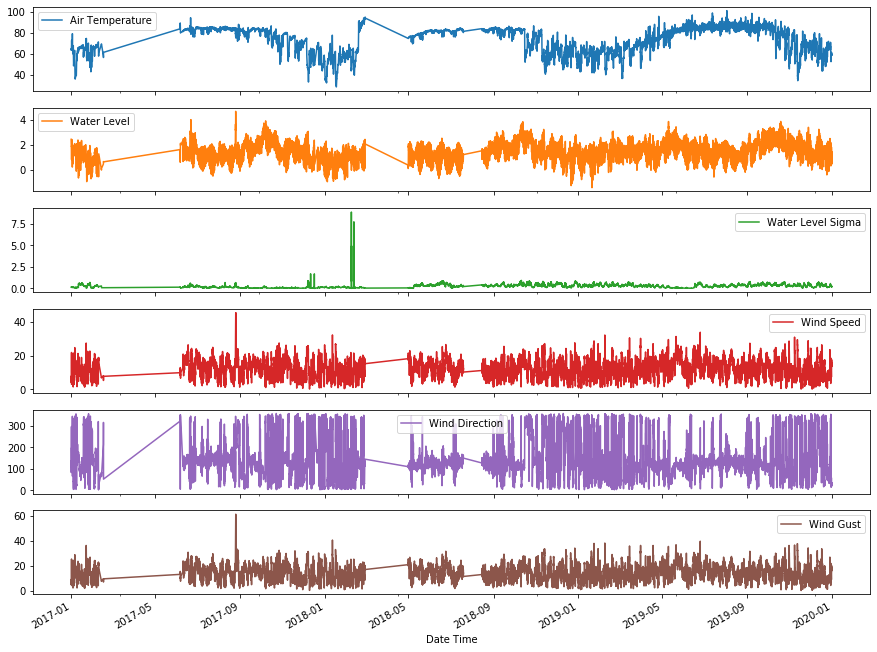

In [8]:
cleaned_train = clean_tide_data(orig_train)
cleaned_train.plot(x='Date Time', figsize=(15, 12), subplots=True)

cleaned_test = clean_tide_data(orig_test)

# Preprocessing

Merging back train and test data for easy differencing

In [46]:
merged = pd.concat([orig_train, orig_test])
merged

,Date Time,Air Temperature,Water Level,Water Level Sigma,Wind Speed,Wind Direction,Wind Gust
0,2017-01-01 00:00:00,63.900000,2.447500,0.149200,4.860000,136.111111,5.355556
1,2017-01-01 01:00:00,63.980000,2.246100,0.162900,4.237000,134.200000,4.666000
2,2017-01-01 02:00:00,64.180000,2.250600,0.153900,5.073000,129.700000,5.404000
3,2017-01-01 03:00:00,64.300000,2.102700,0.160800,5.015000,112.200000,5.287000
4,2017-01-01 04:00:00,64.180000,2.027900,0.168600,6.725000,82.800000,7.115000
...,...,...,...,...,...,...,...
7053,2020-10-20 21:00:00,80.440000,1.858000,0.385200,12.091000,74.600000,13.783000
7054,2020-10-20 22:00:00,79.770000,2.366700,0.380500,12.206000,78.600000,13.898000
7055,2020-10-20 23:00:00,79.430000,2.721800,0.384300,12.497000,74.900000,14.228000
7056,2020-10-21 00:00:00,79.320000,2.967100,0.399600,13.431000,78.600000,15.298000


## Stationary  test

In [9]:
def stationary_test(df):
    result = adfuller(df)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

In [47]:
water_level_df = merged[['Date Time', 'Water Level']].copy().set_index('Date Time')
water_level_df.dropna(inplace=True)
stationary_test(water_level_df['Water Level'].values)

ADF Statistic: -8.372670
p-value: 0.000000


The p-value is significant enough, so it might be tempted to conclude that the data is already stationary.  

However, we know that the data should be seasonal, as in

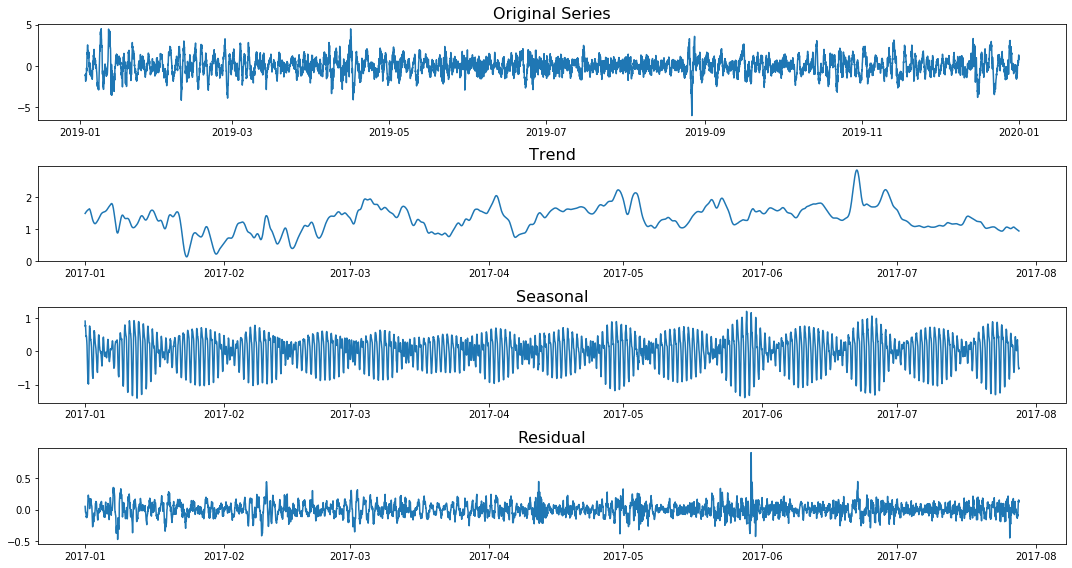

In [60]:
stl = STL(water_level_df['Water Level'][:5000])
result = stl.fit()

seasonal, trend, resid = result.seasonal, result.trend, result.resid

plt.figure(figsize=(15,8))

plt.subplot(4,1,1)
plt.plot(wl_train)
plt.title('Original Series', fontsize=16)

plt.subplot(4,1,2)
plt.plot(trend)
plt.title('Trend', fontsize=16)

plt.subplot(4,1,3)
plt.plot(seasonal)
plt.title('Seasonal', fontsize=16)

plt.subplot(4,1,4)
plt.plot(resid)
plt.title('Residual', fontsize=16)

plt.tight_layout()

### Performing differencing

ADF Statistic: -24.244075
p-value: 0.000000


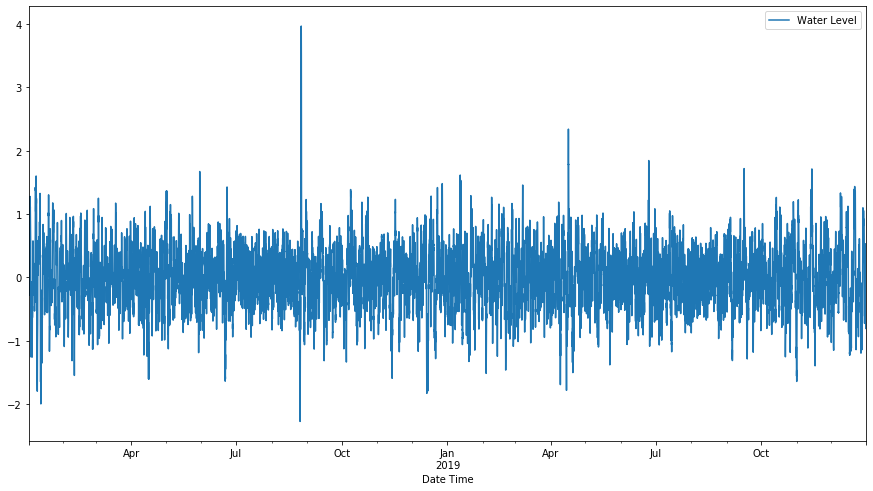

In [75]:
water_level_df = water_level_df.diff(periods=24).dropna()         # by 1 day
water_level_df = water_level_df.diff(periods=365*24).dropna()     # by 1 year
stationary_test(water_level_df)
wl_train.plot(figsize=(15,8))

### Splitting back into train and test set

In [73]:
boundary = pd.to_datetime('2020/01/01')
wl_train = water_level_df[:boundary-timedelta(days=1)]
wl_test = water_level_df[boundary:]
# wl_train
# wl_test

## ACF and PACF

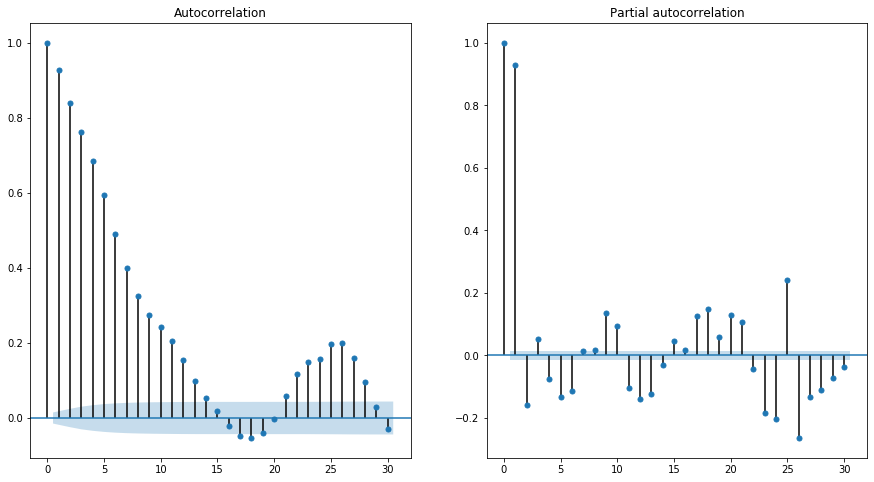

In [74]:
fig, ax = plt.subplots(1,2,figsize=(15,8))
lags = 30
sm.graphics.tsa.plot_acf(wl_train, lags=lags, ax=ax[0], title='Autocorrelation')
sm.graphics.tsa.plot_pacf(wl_train, lags=lags, ax=ax[1], title='Partial autocorrelation')
pass

For ACF, we can see that 25 is the most significant lag, so let's try with seasonality of around 24-25.

# SARIMA model

In [76]:
def train_model(df, periodicity=24, track_time=False):
    model = SARIMAX(df, order=(0,1,0), seasonal_order=(1,0,1,periodicity))

    #fit the model
    start = time()
    model_fit = model.fit()
    end = time()
    if track_time:
        print('Model Fitting Time:', end - start)
    
    return model_fit

### Brute-force

Let's calculate the AIC of some reasonable periods

In [79]:
periods = [6,12,18,24,25]
for period in periods:
    model = train_model(wl_train['Water Level'].values, period)
    print('{} {}'.format(period, model.aic))

6 -10663.603623458795
12 -12182.544265754028
18 -10817.024915202173
24 -13553.8247153439
25 -12483.64153879625


Since a period 24 hours gives lowest value of AIC, we're gonna use that for now.

In [94]:
model = train_model(wl_train['Water Level'].values)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                17473
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 24)   Log Likelihood                6779.912
Date:                              Mon, 02 Nov 2020   AIC                         -13553.825
Time:                                      00:57:09   BIC                         -13530.520
Sample:                                           0   HQIC                        -13546.150
                                            - 17473                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L24       0.6714      0.005    123.532      0.000       0.661       0.682
ma.S.L24      -1.0000      0.788     -1.269      0.204      -2.545       0.545
sigma2         0.0268      0.021      1.271      0.204      -0.015       0.068
===================================================================================
Ljung-Box (L1) (Q):                 849.13   Jarque-Bera (JB):              1691.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
#get the predictions and residuals
predictions = model.forecast(len(wl_test)+1)
predictions = pd.DataFrame(predictions[1:], columns=['Water Level'], index=wl_test.index)
residuals = wl_test - predictions

In [91]:
# predictions

,Water Level
count,7056.000000
mean,0.000855
std,0.541965
min,-4.094484
25%,-0.307859
50%,0.003728
75%,0.330841
max,4.411316


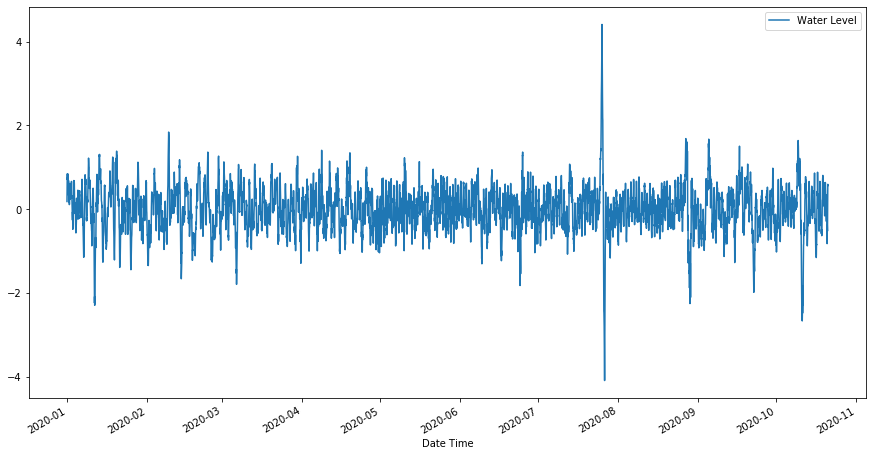

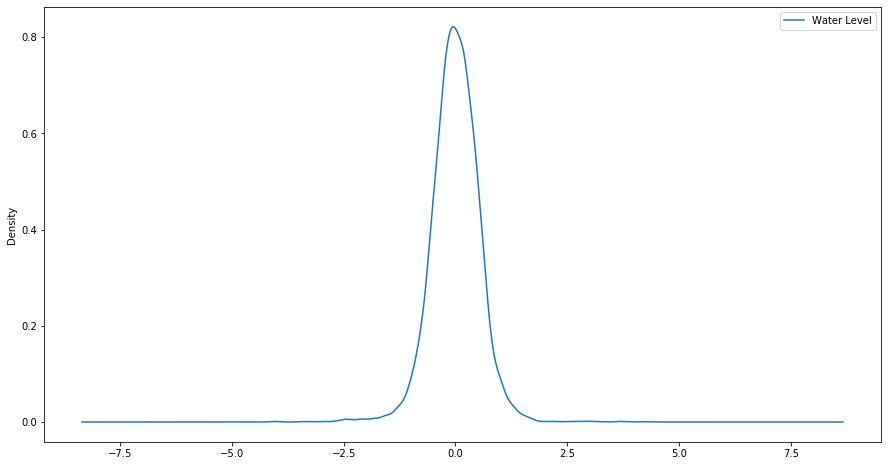

In [96]:
residuals.plot(figsize=(15,8))
residuals.plot(kind='kde', figsize=(15,8))
residuals.describe()

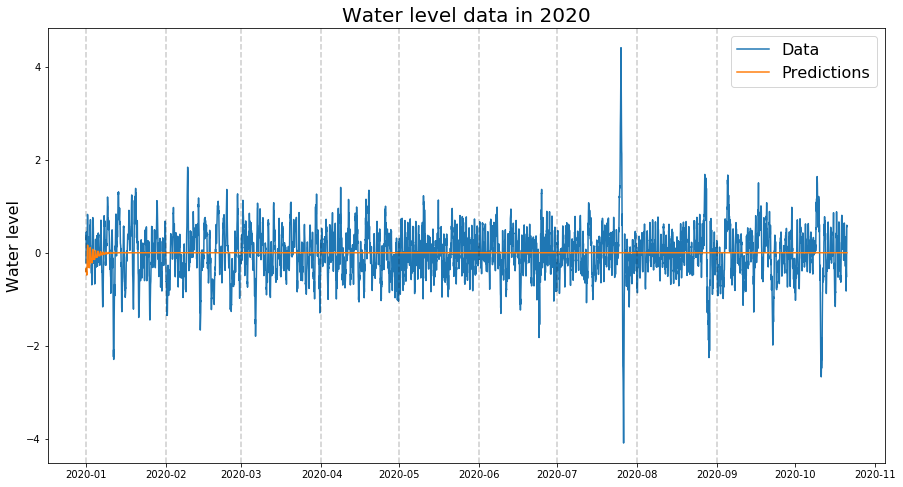

In [97]:
plt.figure(figsize=(15,8))

plt.plot(wl_test)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Water level data in 2020', fontsize=20)
plt.ylabel('Water level', fontsize=16)
for month in range(1,10):
    plt.axvline(pd.to_datetime('2020-' + str(month) + '-01'), color='k', linestyle='--', alpha=0.2)

To be honest, I have no idea why it predicts constant result for most cases. But since the data has a mean of around 0, the mean squared error is obviously quite small.

In [98]:
mean_squared_error(wl_test, predictions)

0.29368489359425004

## Using the Rolling Forecast Origin

Since above implementation didn't work, I decided to do a rolling forecast.  
Basically, it builds the  model, then predicts one day, then rebuilds the model, then predicts the next day, and so on.

In [87]:
from IPython.display import display, clear_output

history = [x for x in wl_train['Water Level'].values]
future = wl_test['Water Level'].copy()
rolling_pred = list()

# time tracking
start = time()

steps = 24    # a day
total_steps = int(len(wl_test) / steps)

for t in range(total_steps):
    print("Date: {}/{}".format(t, total_steps), sep = ' ', end=' ', flush='True')
    
    # train
    model = train_model(history)
    
    # predict
    output = model.forecast(steps)
    yhat = output
    rolling_pred.extend(yhat)
    
    # add current day to training data
    obs = future[t:t+steps].values
    history.extend(obs)
    
    clear_output(wait=True)
    # print(str(t) + '\npredicted={}\nexpected={}'.format(yhat, obs))

clear_output(wait=True)
print('Total time: {:.2f} sec', time() - start)

Date 293/294 

In [ ]:
rolling_pred = pd.DataFrame(rolling_pred[1:], columns=['Water Level'], index=wl_test[1:].index)

NameError: name 'rolling_pred' is not defined

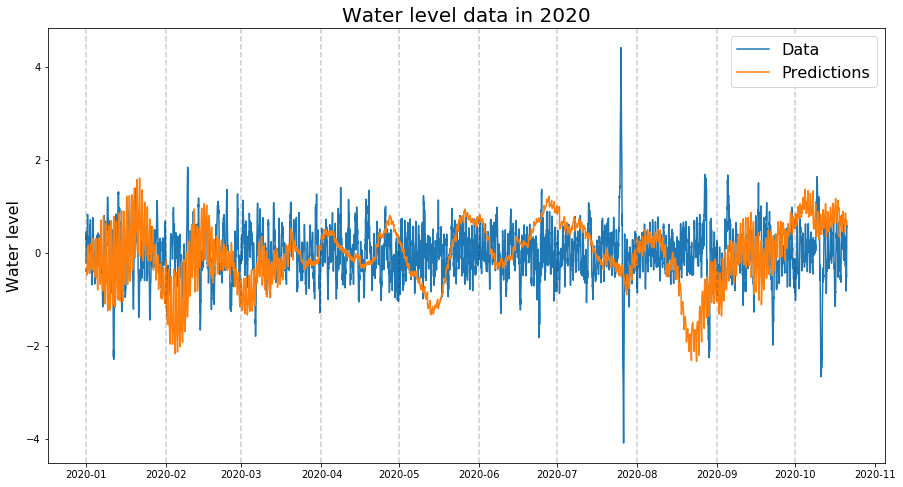

In [100]:
plt.figure(figsize=(15,8))

plt.plot(wl_test)

plt.plot(pred)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Water level data in 2020', fontsize=20)
plt.ylabel('Water level', fontsize=16)
for month in range(1,11):
    plt.axvline(pd.to_datetime('2020-' + str(month) + '-01'), color='k', linestyle='--', alpha=0.2)
    
error = mean_squared_error(wl_test, rolling_pred)
print('Test MSE: %.3f' % error)